In [10]:
import pytreenet as ptn
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy , copy

# Exact (Qutip)

In [11]:
# System initialization
Lx = 4
Ly = 4

t = 2
u = 0.1
mu = 0



n_bosons = 2
system = ptn.BoseHubbard2D_Qutip(Lx, Ly, n_bosons, t, u, mu)

# Create initial state
black_state = np.array([0,1])
white_state = np.array([1,0])
psi0 = system.alternating_product_state(black_state, white_state, pattern= "checkerboard")
psi0 = system.uniform_product_state([1/np.sqrt(2), 1/np.sqrt(2)])
# Evolve system
end_time = 1
dt = 0.01
result = system.evolve_system(psi0, end_time=end_time, dt=dt)


# 2TDVP on MPS (TenPy)

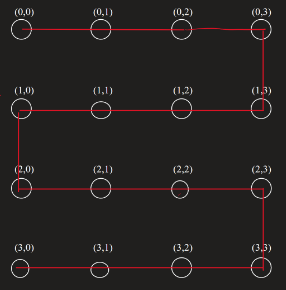

In [ ]:
# Set up parameters
Lx = 4
Ly = 4
n_bosons = 2
t = 2
U = 0.1
mu = 0.5

# Create model and initial state
model = ptn.BoseHubbard2D_Tenpy(Lx, Ly, n_bosons, t, U, mu)
black_state = [0, 1]  # |0>
white_state = [1, 0]  # |1>
mps = model.alternating_product_state_custom(black_state, white_state, pattern="checkerboard")

# Print initial state energy
print("Initial energy:", model.H_MPO.expectation_value(mps))

# Print initial occupation for a few sites
print("Initial occupations:")
occ_initial = model.calculate_occupation(mps)
print(occ_initial)  # Print first 2x2 corner

# Evolution parameters
lanczos_params = {
    'N_min': 2,           # Min number of Lanczos steps per /5
    'N_max': 20,          # Max number of Lanczos steps per evolution step/20
    'P_tol': 1e-6,       # Tolerance for convergence in Lanczos /1e-14
    'reortho': False}     # Reorthogonalize vectors in the Krylov space /False
   

# Evolve the state
psi_evolved = model.evolve_system_two_site(mps, 
                                           end_time = 2,
                                           dt = 0.01, 
                                           chi_max = 80, 
                                           svd_min = 1e-3, 
                                           lanczos_params=lanczos_params) 

In [21]:
import pickle
import pandas as pd
from tabulate import tabulate

# Load the Pickle file
with open('tdvp_profiling_data.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

# Extract profiling data (not profiling details)
profiling_data = loaded_data['profiling_data']
unique_cache_calls = set(entry['update_tree_cache_calls'] for entry in profiling_data)
unique_cache_calls = sorted(unique_cache_calls)
print("Available cache_calls_ncalls values:", unique_cache_calls)

# Compute scores using the profiling_data
# Ensure ptn.compute_scores is compatible with this structure
scored_data = ptn.compute_scores(profiling_data, 36 , alpha=1, gamma=1)

# Convert the scored data to a DataFrame for display
scored_df = pd.DataFrame(scored_data)

# Sort the DataFrame by the 'Score' column in descending order
scored_df = scored_df.sort_values(by='Score', ascending=False)

# Display the top configurations
print("\n=== Top Configurations ===")
print(tabulate(scored_df, headers='keys', tablefmt='pretty'))


Available cache_calls_ncalls values: [30, 32, 34, 36, 38, 40, 42, 44, 46, 48]

=== Top Configurations ===
+----+------------+---------------------+-------------------------+--------------------+----------------------+----------------------+----------------------+---------------------+
|    | Config_ID  |   Running_Time_s    | update_tree_cache_calls |        WPLI        |   Z_Running_Time_s   |        Z_WPLI        |        Score         |  Normalized_Score   |
+----+------------+---------------------+-------------------------+--------------------+----------------------+----------------------+----------------------+---------------------+
| 18 | Config 146 | 0.16407394409179688 |           36            | 8.079284198338765  |  0.3431395288559067  |  1.8360004411670772  |  2.179139970022984   |         1.0         |
| 9  | Config 95  | 0.18011188507080078 |           36            | 8.025471806663692  | 0.23407097620871148  |  1.7218833182532605  |  1.9559542944619719  | 0.96506462494530

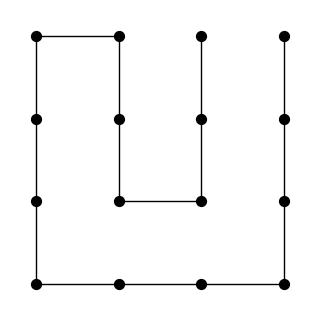

In [25]:
# Load the Pickle file
with open('tdvp_profiling_data.pkl', 'rb') as f:
    profiling_data = pickle.load(f)

# Extract profiling details from the loaded data
profiling_details = profiling_data['profiling_details']

config_id = 'Config 82'
ttn = profiling_details[config_id]['Spanning_tree']
ptn.Visualize_tree(profiling_details[config_id]['tree_dict'],6)  

In [26]:
local_state = np.array([1/np.sqrt(2), 1/np.sqrt(2)])
ttn = ptn.uniform_product_state(ttn ,local_state, bond_dim= 2)

black_state = np.array([0,1])
white_state = np.array([1,0])
#ttn = ptn.alternating_product_state(ttn, black_state, white_state, bond_dim = 2,  pattern = "checkerboard")

t = 2
u = 0.1
m = 0
Lx = 4
Ly = 4

H1 = ptn.BoseHubbard_ham(t, u, m, Lx, Ly, 2)
H1 = H1.pad_with_identities(ttn , symbolic= True)
ttno = ptn.TTNO.from_hamiltonian(H1, ttn)

Correlation_function = ptn.Correlation_function("Site(0,0)", "Site(3,3)", 2)
Correlation_function = Correlation_function.pad_with_identities(ttn, symbolic= True)
Correlation_function_longest = ptn.TTNO.from_hamiltonian(Correlation_function, ttn)

Correlation_function = ptn.spatial_correlation_function(4,4,3,2)
Correlation_function = Correlation_function.pad_with_identities(ttn, symbolic= True)
Correlation_function = ptn.TTNO.from_hamiltonian(Correlation_function, ttn)

I = ptn.TTNO.Identity(ttn)

In [27]:
expansion_params = {"ExpansionMode": ptn.ExpansionMode.TTN,
                    "num_vecs": 3, 
                      "tau": 0.01,
                    "SVDParameters": ptn.SVDParameters(max_bond_dim = np.inf , rel_tol= -np.inf , total_tol = -np.inf),
                    "expansion_steps" : 6,
                    "tol": 0.2,
                    "tol_step_increase": 0.08,
                    "tol_step_decrease": 0.01,
                    "num_second_trial" : 10,
                    "max_bond": 350,
                    "rel_tot_bond": (5,60)}


config= ptn.TTNTimeEvolutionConfig(record_bond_dim = True,
                                   Expansion_params = expansion_params)    

tdvp = ptn.SecondOrderOneSiteTDVP(initial_state = ttn,
                                 hamiltonian = ttno,
                                 time_step_size = 0.01,
                                 final_time = 1,
                                 operators = [Correlation_function , Correlation_function_longest],
                                 config = config)

In [ ]:
tdvp.RUN(evaluation_time = 2 , filepath = r"C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results\3")
times = tdvp.times()

 10%|▉         | 10/101 [00:00<00:04, 22.10it/s]

SVD MAX: 3
Initial tol: 0.2
Acceptable expansion found in initial attempt: 27
Final expanded_dim: 27 : 45 ---> 72


 13%|█▎        | 13/101 [00:00<00:04, 20.51it/s]

SVD MAX: 10
Initial tol: 0.2
Acceptable expansion found in initial attempt: 21
Final expanded_dim: 21 : 72 ---> 93


 20%|█▉        | 20/101 [00:01<00:06, 12.91it/s]

SVD MAX: 11
Initial tol: 0.2
Acceptable expansion found in initial attempt: 27
Final expanded_dim: 27 : 93 ---> 120


 28%|██▊       | 28/101 [00:02<00:11,  6.45it/s]

SVD MAX: 12
Initial tol: 0.2
Acceptable expansion found in initial attempt: 29
Final expanded_dim: 29 : 120 ---> 149


 35%|███▍      | 35/101 [00:04<00:17,  3.81it/s]

SVD MAX: 15
Initial tol: 0.2
Acceptable expansion found in initial attempt: 31
Final expanded_dim: 31 : 149 ---> 180


 41%|████      | 41/101 [00:07<00:25,  2.35it/s]

SVD MAX: 19
Initial tol: 0.2


 42%|████▏     | 42/101 [00:07<00:29,  2.00it/s]

Acceptable expansion found in initial attempt: 39
Final expanded_dim: 39 : 180 ---> 219


 48%|████▊     | 48/101 [00:15<01:02,  1.19s/it]

SVD MAX: 24
Initial tol: 0.2


 49%|████▊     | 49/101 [00:17<01:06,  1.27s/it]

Acceptable expansion found in initial attempt: 51
Final expanded_dim: 51 : 219 ---> 270


 54%|█████▍    | 55/101 [00:33<02:02,  2.66s/it]

SVD MAX: 30
Initial tol: 0.2


 55%|█████▌    | 56/101 [00:38<02:30,  3.34s/it]

Acceptable expansion found in initial attempt: 46
Final expanded_dim: 46 : 270 ---> 316


 61%|██████▏   | 62/101 [01:28<06:08,  9.44s/it]

SVD MAX: 39
Initial tol: 0.2


 62%|██████▏   | 63/101 [01:46<07:33, 11.94s/it]

Acceptable expansion found in initial attempt: 46
Exceed max bond dimension: 350
Final expanded_dim: 46 : 316 ---> 362


 98%|█████████▊| 99/101 [06:44<00:17,  8.65s/it]

c:\Users\edpou\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\edpou\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


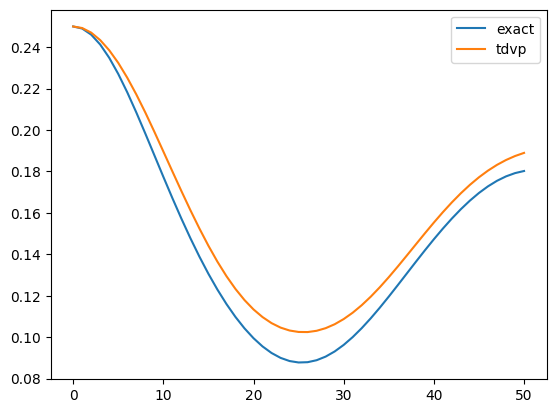

In [17]:
correlation_exact, eval_times = system.spatial_correlation_function_results(evaluation_time =2 , 
                                                                            results = result, 
                                                                            distance = 3, 
                                                                            mode="HV", 
                                                                            Normalize=False)

plt.plot(correlation_exact, label="exact")
plt.plot(tdvp.operator_results()[0], label="tdvp")
plt.legend()

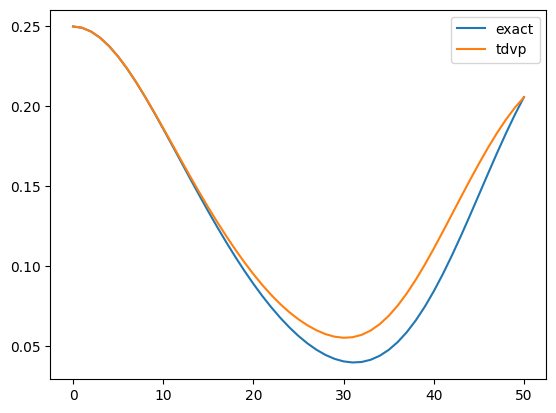

In [18]:
correlation_exact_longest, eval_times = system.specific_site_correlation_results(evaluation_time=2,
                                                                     results=result ,
                                                                     site1 = (0,0),
                                                                     site2 = (3,3),
                                                                     normalize = False)

plt.plot(correlation_exact_longest, label="exact")
plt.plot(tdvp.operator_results()[1], label="tdvp")
plt.legend()

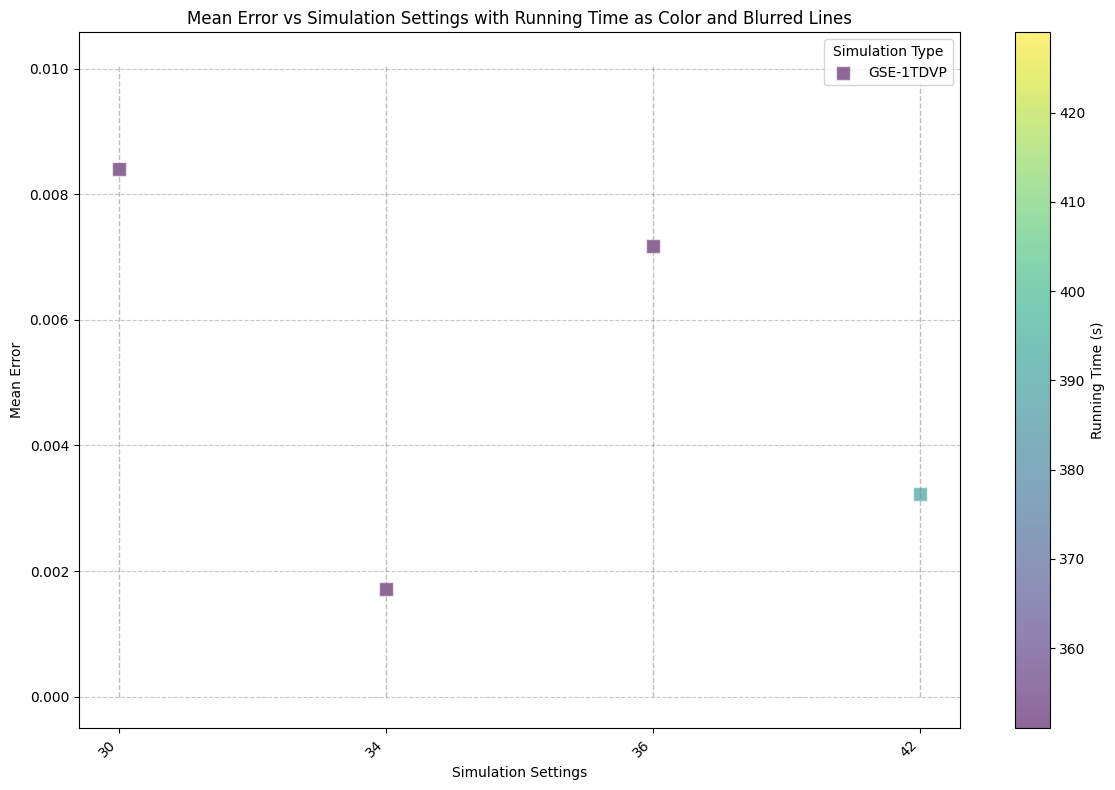

In [228]:
import matplotlib.pyplot as plt
import numpy as np

def plot_simulation_results(exact_solution, simulation_data):
    """
    Generate a bubble plot to visualize mean error vs simulation settings with blurred lines for each simulation type.

    Parameters:
    - exact_solution: np.ndarray, the exact solution values.
    - simulation_data: dict, where each key corresponds to a simulation setting name and value contains:
        - 'types': list of str, types of simulations (e.g., ["2TDVP", "GSE-1TDVP"])
        - 'running_times': list of float, running times corresponding to each type
        - 'results': list of list of np.ndarray, results for each simulation type

    Returns:
    - None: Displays the plot.
    """
    labels = []
    mean_errors = []
    running_times = []
    types = []
    x_positions = []

    current_x = 0
    for setting, data in simulation_data.items():
        for sim_type, running_time, results in zip(data['types'], data['running_times'], data['results']):
            # Ensure results and exact_solution have matching shapes
            results = np.array(results).real
            exact_solution = exact_solution.real

            if results.shape != exact_solution.shape:
                raise ValueError(f"Shape mismatch: results shape {results.shape} and exact_solution shape {exact_solution.shape} must match.")
            
            labels.append(f"{setting} ({sim_type})")
            x_positions.append(current_x)
            types.append(sim_type)
            running_times.append(running_time)

            # Calculate aggregated errors
            errors = np.abs(results - exact_solution)
            mean_errors.append(np.mean(errors))

        current_x += 1

    # Define marker types for simulation types
    marker_map = {'2TDVP': 'o', 'GSE-1TDVP': 's'}

    # Bubble plot with distinct markers
    plt.figure(figsize=(12, 8))
    for i, (x, sim_type, running_time) in enumerate(zip(x_positions, types, running_times)):
        plt.scatter(
            x, mean_errors[i], 
            s=100,  # Fixed bubble size
            c=[running_time], 
            cmap='viridis', 
            alpha=0.6, 
            edgecolors="w", 
            linewidth=1, 
            marker=marker_map[sim_type],
            label=sim_type if sim_type not in plt.gca().get_legend_handles_labels()[1] else None  # Add legend once per type
        )

    # Determine y-axis range
    max_y = max(mean_errors) * 1.2  # Extend slightly above maximum error

    # Add blur lines
    for i, (x, sim_type) in enumerate(zip(x_positions, types)):
        linestyle = '-' if sim_type == '2TDVP' else '--'
        plt.plot([x, x], [0, max_y], alpha=0.5, color='gray', linewidth=1, linestyle=linestyle)

    # Add labels
    plt.xticks(range(len(simulation_data)), simulation_data.keys(), rotation=45, ha='right')
    plt.colorbar(label="Running Time (s)")
    plt.legend(title="Simulation Type", loc='upper right')

    plt.xlabel("Simulation Settings")
    plt.ylabel("Mean Error")
    plt.title("Mean Error vs Simulation Settings with Running Time as Color and Blurred Lines")
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Usage Example
exact_solution = correlation_exact

simulation_data = {
        '30': {
    'types': ['GSE-1TDVP'],
    'running_times': [390],
    'results': [
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results\30_82_570.npz')["operator0results"],
    ],
    },
            '34': {
    'types': ['GSE-1TDVP'],
    'running_times': [390],
    'results': [
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results\34_90_450.npz')["operator0results"],
    ],
    },
     '36': {
    'types': ['GSE-1TDVP'],
    'running_times': [390],
    'results': [
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results\3.npz')["operator0results"],
    ],
    },
            '42': {
    'types': ['GSE-1TDVP'],
    'running_times': [390],
    'results': [
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results\42_136_620.npz')["operator0results"],
    ],
    },
}

plot_simulation_results(exact_solution, simulation_data)


In [ ]:
#30 34 42 does not have longest

In [230]:
tdvp.total_bond_dim

[45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 68,
 68,
 68,
 68,
 68,
 68,
 68,
 68,
 68,
 68,
 68,
 68,
 68,
 68,
 68,
 68,
 68,
 68,
 68,
 104,
 104,
 104,
 104,
 104,
 104,
 104,
 104,
 104,
 104,
 104,
 104,
 104,
 104,
 104,
 104,
 104,
 104,
 104,
 104,
 127,
 127,
 127,
 127,
 127,
 127,
 127,
 127,
 127,
 127,
 127,
 127,
 127,
 127,
 127,
 127,
 127,
 127,
 127,
 165,
 165,
 165,
 165,
 165,
 165,
 165,
 165,
 165,
 165,
 165,
 165,
 165,
 165,
 165,
 165,
 165,
 165,
 165,
 165,
 203,
 203,
 203,
 203,
 203,
 203,
 203,
 203,
 203,
 203,
 203,
 203,
 203,
 203,
 203,
 203,
 203,
 203,
 203,
 249,
 249,
 249,
 249,
 249,
 249,
 249,
 249,
 249,
 249,
 249,
 249,
 249,
 249,
 249,
 249,
 249,
 249,
 249,
 249,
 249,
 249,
 249,
 249,
 249,
 249,
 249,
 249,
 249,
 249,
 249,
 249,
 249,
 249,
 249,
 249]

In [173]:
L30_82_570 = [45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 64,
 64,
 64,
 64,
 64,
 64,
 64,
 64,
 64,
 92,
 92,
 92,
 92,
 92,
 92,
 92,
 92,
 92,
 116,
 116,
 116,
 116,
 116,
 116,
 116,
 116,
 116,
 139,
 139,
 139,
 139,
 139,
 139,
 139,
 139,
 139,
 167,
 167,
 167,
 167,
 167,
 167,
 167,
 167,
 167,
 196,
 196,
 196,
 196,
 196,
 196,
 196,
 196,
 196,
 221,
 221,
 221,
 221,
 221,
 221,
 221,
 221,
 221,
 252,
 252,
 252,
 252,
 252,
 252,
 252,
 252,
 252,
 292,
 292,
 292,
 292,
 292,
 292,
 292,
 292,
 292,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341]

In [190]:
L42_136_620 = [45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 71,
 71,
 71,
 71,
 71,
 71,
 71,
 71,
 71,
 71,
 71,
 71,
 71,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 107,
 107,
 107,
 107,
 107,
 107,
 107,
 107,
 107,
 107,
 107,
 107,
 107,
 118,
 118,
 118,
 118,
 118,
 118,
 118,
 118,
 118,
 118,
 118,
 118,
 118,
 118,
 142,
 142,
 142,
 142,
 142,
 142,
 142,
 142,
 142,
 142,
 142,
 142,
 142,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149]

In [205]:
L_34_90_450 = [45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 72,
 72,
 72,
 72,
 72,
 72,
 72,
 72,
 72,
 72,
 95,
 95,
 95,
 95,
 95,
 95,
 95,
 95,
 95,
 95,
 95,
 121,
 121,
 121,
 121,
 121,
 121,
 121,
 121,
 121,
 121,
 153,
 153,
 153,
 153,
 153,
 153,
 153,
 153,
 153,
 153,
 153,
 172,
 172,
 172,
 172,
 172,
 172,
 172,
 172,
 172,
 172,
 199,
 199,
 199,
 199,
 199,
 199,
 199,
 199,
 199,
 199,
 199,
 235,
 235,
 235,
 235,
 235,
 235,
 235,
 235,
 235,
 235,
 235,
 235,
 235,
 235,
 235,
 235,
 235,
 235,
 235,
 235,
 235,
 235,
 235,
 235,
 235,
 235,
 235,
 235,
 235,
 235,
 235,
 235,
 235,
 235,
 235,
 235,
 235,
 235,
 235,
 235,
 235,
 235,
 235,
 235,
 235,
 235,
 235,
 235,
 235,
 235,
 235,
 235,
 235,
 235,
 235,
 235,
 235,
 235,
 235,
 235,
 235,
 235,
 235,
 235,
 235,
 235,
 235,
 235,
 235,
 235,
 235,
 235,
 235,
 235,
 235,
 235,
 235,
 235,
 235]

In [231]:
L_36_60_1000 = [45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 68,
 68,
 68,
 68,
 68,
 68,
 68,
 68,
 68,
 68,
 68,
 68,
 68,
 68,
 68,
 68,
 68,
 68,
 68,
 104,
 104,
 104,
 104,
 104,
 104,
 104,
 104,
 104,
 104,
 104,
 104,
 104,
 104,
 104,
 104,
 104,
 104,
 104,
 104,
 127,
 127,
 127,
 127,
 127,
 127,
 127,
 127,
 127,
 127,
 127,
 127,
 127,
 127,
 127,
 127,
 127,
 127,
 127,
 165,
 165,
 165,
 165,
 165,
 165,
 165,
 165,
 165,
 165,
 165,
 165,
 165,
 165,
 165,
 165,
 165,
 165,
 165,
 165,
 203,
 203,
 203,
 203,
 203,
 203,
 203,
 203,
 203,
 203,
 203,
 203,
 203,
 203,
 203,
 203,
 203,
 203,
 203,
 249,
 249,
 249,
 249,
 249,
 249,
 249,
 249,
 249,
 249,
 249,
 249,
 249,
 249,
 249,
 249,
 249,
 249,
 249,
 249,
 249,
 249,
 249,
 249,
 249,
 249,
 249,
 249,
 249,
 249,
 249,
 249,
 249,
 249,
 249,
 249]

C:\Users\edpou\AppData\Local\Temp\ipykernel_16000\575452628.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab20')  # Choose a colormap with more distinct colors


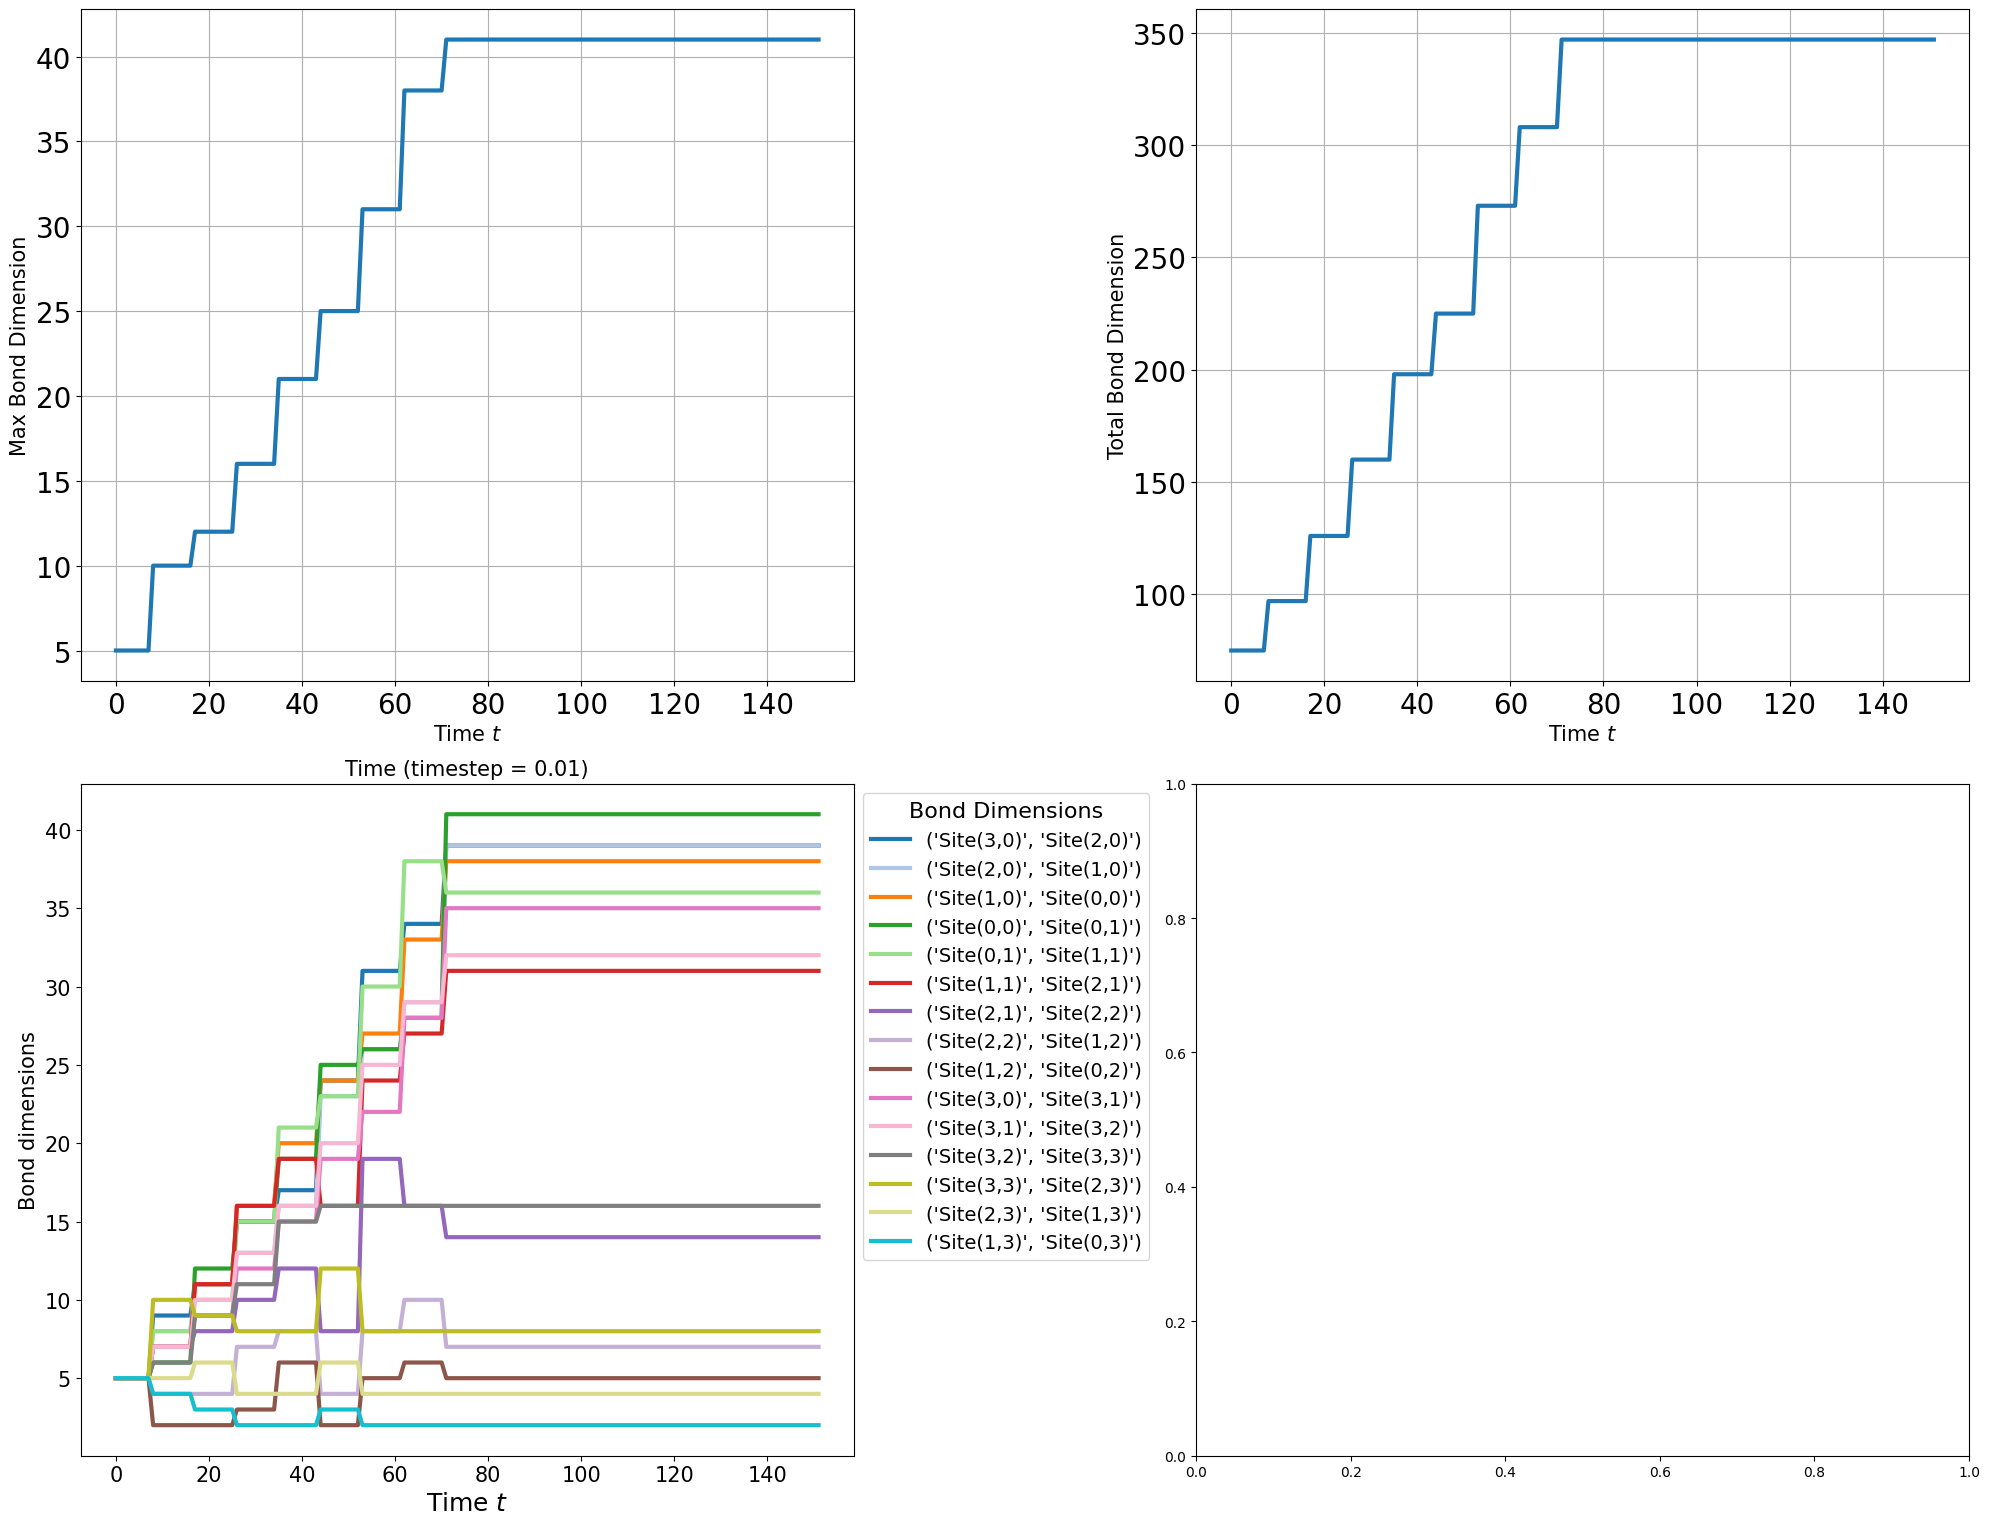

In [73]:
import matplotlib.pyplot as plt

def get_distinct_colors(n):
    """Generates a list of n distinct, visually appealing colors using colormap cyclically."""
    from matplotlib.cm import get_cmap
    cmap = get_cmap('tab20')  # Choose a colormap with more distinct colors
    return [cmap(i / n) for i in range(n)]

# Create a figure with a grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(20, 16))

# Plot max bond dimension
axs[0, 0].plot(tdvp.max_bond_dim, linewidth=3)
axs[0, 0].set_xlabel("Time $t$", fontsize=15)
axs[0, 0].set_ylabel('Max Bond Dimension', fontsize=15)
axs[0, 0].tick_params(axis='both', which='major', labelsize=20)
axs[0, 0].grid(True)

# Plot total bond dimension
axs[0, 1].plot(tdvp.total_bond_dim, linewidth=3)
axs[0, 1].set_xlabel("Time $t$", fontsize=15)
axs[0, 1].set_ylabel('Total Bond Dimension', fontsize=15)
axs[0, 1].tick_params(axis='both', which='major', labelsize=20)
axs[0, 1].grid(True)

# Plot bond dimensions for each key
colors = get_distinct_colors(len(tdvp.bond_dims))
for i, (key, values) in enumerate(tdvp.bond_dims.items()):
    x = list(range(len(values)))
    axs[1, 0].plot(x, values, label=key, color=colors[i], linewidth=3)
axs[1, 0].legend(title='Bond Dimensions', loc='upper left', bbox_to_anchor=(1, 1), fontsize=14, title_fontsize=16)
axs[1, 0].set_xlabel("Time $t$", fontsize=18)
axs[1, 0].set_ylabel('Bond dimensions', fontsize=15)
axs[1, 0].set_title('Time (timestep = 0.01)', fontsize=15)
axs[1, 0].tick_params(axis='both', which='major', labelsize=15)
plt.subplots_adjust(right=0.8)


# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for the title

# Show the plot
plt.show()


In [ ]:
oc_exact, times = system.occupation_results(evaluation_time=2,results=result)
oc_exact_00 = oc_exact[:,2,2]
oc_tenpy, times = model.occupation_results(psi_list= psi_evolved, evaluation_time=2, dt = 0.01)
oc_tenpy = oc_tenpy[:,2,2]
oc_tdvp = tdvp.operator_results()[1]

plt.plot(times, abs(oc_tdvp - oc_exact_00) / oc_exact_00 , label="1tdvp - 2 min")
plt.plot(times, abs(oc_tenpy - oc_exact_00) / oc_exact_00 , label="tenpy - 5 min")
#plt.plot(times, oc_exact_00, label="exact")

plt.title("(0,0) occupation error")
plt.xlabel("Time")
plt.ylabel("Spatial Correlation")
plt.legend()
plt.show()

In [ ]:
correlation_exact, eval_times = system.specific_site_correlation_results(evaluation_time=2,
                                                                     results=result ,
                                                                     site1 = (0,0),
                                                                     site2 = (3,3),
                                                                     normalize = False)


plt.plot(times, abs(tdvp.operator_results()[0]), label="1tdvp - 2 min")
#plt.plot(times, correlation_tenpy, label="tenpy - 5 min")
plt.plot(times, correlation_exact, label="exact")

plt.title("(0,0)-(3,3) Correlation")
plt.xlabel("Time")
plt.ylabel("Spatial Correlation")
plt.legend()
plt.show()